In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchsummary import summary

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4070 SUPER
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [3]:
device

device(type='cuda')

In [4]:
pd.read_csv('./data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [5]:
categories = pd.read_csv('./data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [6]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [7]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (В моем случае, 'drive/MyDrive/DataSets/human_poses_data/img_train').
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        label = self.labels.iloc[idx, 1]  # target_feature (метка)

        # Загружаем изображение
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")  # Убедимся, что изображение в RGB

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
RANDOM_SEED = 52
torch.manual_seed(RANDOM_SEED)

In [10]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 20


In [11]:
dataset = HumanPoseDataset(
    img_dir='./data/img_train',
    csv_file='./data/train_answers.csv',
    transform=transform
)

train_dataset, val_dataset = random_split(dataset, [int(0.9*len(dataset)), len(dataset) - int(0.9*len(dataset))])

In [12]:
def show_images_row(images, labels, size=(2, 2)):
    """
    Параметры:
    - images: список тензоров изображений
    - labels: список меток
    - size: кортеж (ширина, высота) изображения
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(size[0] * num_images, size[1]))
    if num_images == 1:
        axes = [axes]  # Если одно изображение, делаем axes списком

    for img, label, ax in zip(images, labels, axes):
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f'Label: {id_to_category[label]}')
        ax.axis('off')  # Убираем оси

    plt.tight_layout()
    plt.show()

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.64].


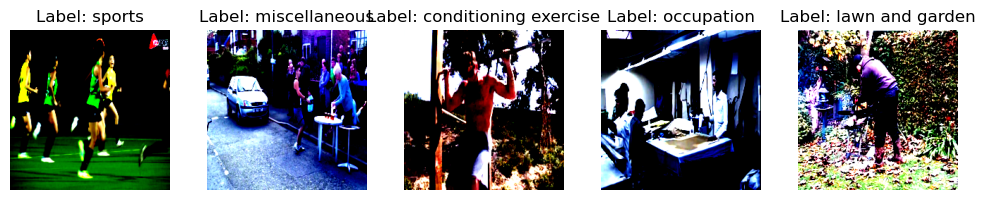

In [14]:
# Получить батч данных
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Вывести первые 5 изображений в одну строку
show_images_row(images[:5], [label.item() for label in labels[:5]], size=(2, 2))

In [15]:
class AlexNetArtem(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetArtem, self).__init__()
        self.num_classes = num_classes
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(
                in_features=4096, out_features=self.num_classes
            ),
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [16]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
len(id_to_category)

20

In [18]:
summary(AlexNet(20).to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

In [19]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging
import tqdm

c:\Users\Vlad\.conda\envs\DL_ENV\lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [20]:
model = AlexNet(20).to(device)

In [21]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

In [22]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=5, tm_hour=20, tm_min=59, tm_sec=58, tm_wday=3, tm_yday=340, tm_isdst=0)

In [23]:
# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()  # Переводим модель в режим обучения
    images, labels = batch
    images, labels = images.to(device), labels.to(device)  # Перенос данных на устройство (CPU/GPU)
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(images)  # Прямой проход (forward pass)
    loss = criterion(outputs, labels)  # Вычисляем функцию потерь
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    # Возвращаем результаты: значение функции потерь, выходы модели и метки
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов (ускоряет выполнение и экономит память)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Прямой проход
        return outputs, labels  # Возвращаем предсказания и истинные метки

# Создаём движки (engines) для тренировки и валидации
trainer = Engine(train_step)  # Движок для обучения
evaluator = Engine(val_step)  # Движок для валидации

# Добавляем метрики для обучения
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_accuracy = Accuracy(output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")  # Привязываем метрику функции потерь к тренеру
train_accuracy.attach(trainer, "accuracy")  # Привязываем метрику точности к тренеру

# Добавляем метрики для валидации
Accuracy().attach(evaluator, "accuracy")  # Точность
Loss(criterion).attach(evaluator, "loss")  # Функция потерь

# Прогресс-бар для отображения статуса обучения
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

cur_time = time.localtime()
path_suf = '_' + str(cur_time.tm_mday) + '_' + str(cur_time.tm_mon) + '_' + str(cur_time.tm_hour) + '_' + str(cur_time.tm_min)

# Настройка логирования
log_dir = "./train_info/logs" + path_suf
os.makedirs(log_dir, exist_ok=True)  # Создаём директорию для логов, если её нет
logging.basicConfig(
    filename="training.log",  # Файл для записи логов
    level=logging.INFO,  # Уровень логирования
    format="%(asctime)s - %(message)s",  # Формат записей
)
logger = logging.getLogger()  # Создаём логгер

# Создаём DataFrame для метрик
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    # Если файл уже существует, загружаем его (например, для продолжения тренировки)
    metrics_df = pd.read_csv(metrics_path)
else:
    # Создаём новый DataFrame, если файла ещё нет
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

# Настраиваем сохранение модели при лучших результатах
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
handler = Checkpoint(
    to_save,  # Что сохранять
    DiskSaver("./train_info/checkpoints" + path_suf, create_dir=True, require_empty=False, atomic=False),  # Диск-сохранитель
    n_saved=3,  # Сохранять только последние 3 чекпоинта
    filename_prefix="best",  # Префикс имени файла
    score_function=lambda engine: engine.state.metrics["accuracy"],  # Критерий выбора "лучшей" модели
    score_name="val_accuracy",  # Название критерия
    global_step_transform=global_step_from_engine(trainer),  # Глобальный шаг (номер итерации)
)

# Добавляем событие для логирования и сохранения метрик после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Получаем метрики для тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_accuracy = train_metrics["accuracy"]
    
    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_accuracy = val_metrics["accuracy"]
    
    # Логируем метрики
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Сохраняем метрики в DataFrame и записываем в CSV
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train Accuracy": [train_accuracy],
            "Validation Loss": [val_loss],
            "Validation Accuracy": [val_accuracy],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)  # Сохраняем таблицу в CSV
    
    # Сохраняем модель
    handler(evaluator)

c:\Users\Vlad\.conda\envs\DL_ENV\lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [24]:
trainer.run(train_loader, max_epochs=100)

C:\Users\Vlad\AppData\Local\Temp\ipykernel_11424\2703107813.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


Epoch 1: Train Loss: 2.6786, Train Accuracy: 0.1951, Validation Loss: 2.5155, Validation Accuracy: 0.2102


Epoch 2: Train Loss: 2.5359, Train Accuracy: 0.2022, Validation Loss: 2.4889, Validation Accuracy: 0.2037


Epoch 3: Train Loss: 2.5090, Train Accuracy: 0.1961, Validation Loss: 2.4955, Validation Accuracy: 0.1964


Epoch 4: Train Loss: 2.4925, Train Accuracy: 0.1992, Validation Loss: 2.4718, Validation Accuracy: 0.2037


Epoch 5: Train Loss: 2.4894, Train Accuracy: 0.2066, Validation Loss: 2.4683, Validation Accuracy: 0.2005


Epoch 6: Train Loss: 2.4461, Train Accuracy: 0.2091, Validation Loss: 2.4251, Validation Accuracy: 0.2045


Epoch 7: Train Loss: 2.3822, Train Accuracy: 0.2282, Validation Loss: 2.3674, Validation Accuracy: 0.2223


Epoch 8: Train Loss: 2.3913, Train Accuracy: 0.2240, Validation Loss: 2.3869, Validation Accuracy: 0.2336


Epoch 9: Train Loss: 2.3542, Train Accuracy: 0.2451, Validation Loss: 2.3146, Validation Accuracy: 0.2336


Epoch 10: Train Loss: 2.3058, Train Accuracy: 0.2560, Validation Loss: 2.2838, Validation Accuracy: 0.2563


Epoch 11: Train Loss: 2.2546, Train Accuracy: 0.2702, Validation Loss: 2.2272, Validation Accuracy: 0.2797


Epoch 12: Train Loss: 2.2128, Train Accuracy: 0.2831, Validation Loss: 2.1937, Validation Accuracy: 0.2757


Epoch 13: Train Loss: 2.1468, Train Accuracy: 0.3022, Validation Loss: 2.1425, Validation Accuracy: 0.3088


Epoch 14: Train Loss: 2.0622, Train Accuracy: 0.3323, Validation Loss: 2.1171, Validation Accuracy: 0.3476


Epoch 15: Train Loss: 1.9824, Train Accuracy: 0.3600, Validation Loss: 2.0648, Validation Accuracy: 0.3371


Epoch 16: Train Loss: 1.8543, Train Accuracy: 0.3971, Validation Loss: 2.0142, Validation Accuracy: 0.3638


Epoch 17: Train Loss: 1.7843, Train Accuracy: 0.4230, Validation Loss: 1.9701, Validation Accuracy: 0.3913


Epoch 18: Train Loss: 1.6345, Train Accuracy: 0.4723, Validation Loss: 1.9782, Validation Accuracy: 0.3864


Epoch 19: Train Loss: 1.5421, Train Accuracy: 0.4996, Validation Loss: 1.9296, Validation Accuracy: 0.4058


Epoch 20: Train Loss: 1.4065, Train Accuracy: 0.5440, Validation Loss: 1.8994, Validation Accuracy: 0.4276


Epoch 21: Train Loss: 1.2552, Train Accuracy: 0.5968, Validation Loss: 1.9479, Validation Accuracy: 0.4293


Epoch 22: Train Loss: 1.1574, Train Accuracy: 0.6231, Validation Loss: 1.9831, Validation Accuracy: 0.4317


Epoch 23: Train Loss: 1.0551, Train Accuracy: 0.6593, Validation Loss: 1.9744, Validation Accuracy: 0.4454


Epoch 24: Train Loss: 0.9412, Train Accuracy: 0.6978, Validation Loss: 2.0059, Validation Accuracy: 0.4519


Epoch 25: Train Loss: 0.8368, Train Accuracy: 0.7285, Validation Loss: 2.0068, Validation Accuracy: 0.4535


Epoch 26: Train Loss: 0.7586, Train Accuracy: 0.7575, Validation Loss: 2.1159, Validation Accuracy: 0.4422


Epoch 27: Train Loss: 0.7181, Train Accuracy: 0.7721, Validation Loss: 2.1276, Validation Accuracy: 0.4511


Epoch 28: Train Loss: 0.6546, Train Accuracy: 0.7892, Validation Loss: 2.2069, Validation Accuracy: 0.4511


Epoch 29: Train Loss: 0.5995, Train Accuracy: 0.8086, Validation Loss: 2.3228, Validation Accuracy: 0.4373


Epoch 30: Train Loss: 0.6669, Train Accuracy: 0.7889, Validation Loss: 2.0795, Validation Accuracy: 0.4616


Epoch 31: Train Loss: 0.5148, Train Accuracy: 0.8361, Validation Loss: 2.3420, Validation Accuracy: 0.4729


Epoch 32: Train Loss: 0.4936, Train Accuracy: 0.8429, Validation Loss: 2.3960, Validation Accuracy: 0.4600


Epoch 33: Train Loss: 0.4567, Train Accuracy: 0.8542, Validation Loss: 2.2564, Validation Accuracy: 0.4568


Epoch 34: Train Loss: 0.4327, Train Accuracy: 0.8618, Validation Loss: 2.3215, Validation Accuracy: 0.4745


Epoch 35: Train Loss: 0.4151, Train Accuracy: 0.8682, Validation Loss: 2.3172, Validation Accuracy: 0.4640


Epoch 36: Train Loss: 0.4108, Train Accuracy: 0.8719, Validation Loss: 2.3297, Validation Accuracy: 0.4479


Epoch 37: Train Loss: 0.3945, Train Accuracy: 0.8756, Validation Loss: 2.3372, Validation Accuracy: 0.4632


Epoch 38: Train Loss: 0.3200, Train Accuracy: 0.8971, Validation Loss: 2.4539, Validation Accuracy: 0.4600


Epoch 39: Train Loss: 0.3346, Train Accuracy: 0.8926, Validation Loss: 2.3391, Validation Accuracy: 0.4640


Epoch 40: Train Loss: 0.3756, Train Accuracy: 0.8835, Validation Loss: 2.4872, Validation Accuracy: 0.4487


Epoch 41: Train Loss: 0.3357, Train Accuracy: 0.8953, Validation Loss: 2.3303, Validation Accuracy: 0.4721


Epoch 42: Train Loss: 0.3324, Train Accuracy: 0.8945, Validation Loss: 2.4299, Validation Accuracy: 0.4729


Epoch 43: Train Loss: 0.3336, Train Accuracy: 0.8940, Validation Loss: 2.5330, Validation Accuracy: 0.4470


Epoch 44: Train Loss: 0.2964, Train Accuracy: 0.9074, Validation Loss: 2.4811, Validation Accuracy: 0.4729


Epoch 45: Train Loss: 0.3076, Train Accuracy: 0.9058, Validation Loss: 2.5141, Validation Accuracy: 0.4794


Epoch 46: Train Loss: 0.2985, Train Accuracy: 0.9066, Validation Loss: 2.5476, Validation Accuracy: 0.4624


Epoch 47: Train Loss: 0.3283, Train Accuracy: 0.8996, Validation Loss: 2.4755, Validation Accuracy: 0.4600


Epoch 48: Train Loss: 0.2915, Train Accuracy: 0.9083, Validation Loss: 2.5888, Validation Accuracy: 0.4535


Epoch 49: Train Loss: 0.3042, Train Accuracy: 0.9072, Validation Loss: 2.5040, Validation Accuracy: 0.4665


Epoch 50: Train Loss: 0.2412, Train Accuracy: 0.9263, Validation Loss: 2.6249, Validation Accuracy: 0.4705


Epoch 51: Train Loss: 0.2211, Train Accuracy: 0.9314, Validation Loss: 2.6778, Validation Accuracy: 0.4656


Epoch 52: Train Loss: 0.3043, Train Accuracy: 0.9043, Validation Loss: 2.5775, Validation Accuracy: 0.4737


Epoch 53: Train Loss: 0.2396, Train Accuracy: 0.9267, Validation Loss: 2.5100, Validation Accuracy: 0.4648


Epoch 54: Train Loss: 0.2900, Train Accuracy: 0.9133, Validation Loss: 2.5311, Validation Accuracy: 0.4762


Epoch 55: Train Loss: 0.2512, Train Accuracy: 0.9255, Validation Loss: 2.5627, Validation Accuracy: 0.4794


Epoch 56: Train Loss: 0.2493, Train Accuracy: 0.9235, Validation Loss: 2.5411, Validation Accuracy: 0.4753


Epoch 57: Train Loss: 0.2170, Train Accuracy: 0.9331, Validation Loss: 2.6445, Validation Accuracy: 0.4818


Epoch 58: Train Loss: 0.2145, Train Accuracy: 0.9342, Validation Loss: 2.6150, Validation Accuracy: 0.4640


Epoch 59: Train Loss: 0.2496, Train Accuracy: 0.9257, Validation Loss: 2.5766, Validation Accuracy: 0.4656


Epoch 60: Train Loss: 0.2278, Train Accuracy: 0.9322, Validation Loss: 2.4998, Validation Accuracy: 0.4584


Epoch 61: Train Loss: 0.2085, Train Accuracy: 0.9376, Validation Loss: 2.5548, Validation Accuracy: 0.4802


Epoch 62: Train Loss: 0.2205, Train Accuracy: 0.9323, Validation Loss: 2.6409, Validation Accuracy: 0.4632


Epoch 63: Train Loss: 0.1899, Train Accuracy: 0.9412, Validation Loss: 2.7181, Validation Accuracy: 0.4681


Epoch 64: Train Loss: 0.2248, Train Accuracy: 0.9344, Validation Loss: 2.5565, Validation Accuracy: 0.4778


Epoch 65: Train Loss: 0.2558, Train Accuracy: 0.9280, Validation Loss: 2.6087, Validation Accuracy: 0.4624


Epoch 66: Train Loss: 0.2059, Train Accuracy: 0.9367, Validation Loss: 2.7404, Validation Accuracy: 0.4584


Epoch 67: Train Loss: 0.2305, Train Accuracy: 0.9314, Validation Loss: 2.4679, Validation Accuracy: 0.4826


Epoch 68: Train Loss: 0.2194, Train Accuracy: 0.9363, Validation Loss: 2.6803, Validation Accuracy: 0.4681


Epoch 69: Train Loss: 0.1794, Train Accuracy: 0.9473, Validation Loss: 2.6770, Validation Accuracy: 0.4689


Epoch 70: Train Loss: 0.1909, Train Accuracy: 0.9438, Validation Loss: 2.8749, Validation Accuracy: 0.4697


Epoch 71: Train Loss: 0.2469, Train Accuracy: 0.9286, Validation Loss: 2.4976, Validation Accuracy: 0.4745


Epoch 72: Train Loss: 0.2106, Train Accuracy: 0.9385, Validation Loss: 2.7215, Validation Accuracy: 0.4883


Epoch 73: Train Loss: 0.2752, Train Accuracy: 0.9265, Validation Loss: 2.5138, Validation Accuracy: 0.4778


Epoch 74: Train Loss: 0.2105, Train Accuracy: 0.9371, Validation Loss: 2.5698, Validation Accuracy: 0.4753


Epoch 75: Train Loss: 0.2060, Train Accuracy: 0.9438, Validation Loss: 2.6461, Validation Accuracy: 0.4818


Epoch 76: Train Loss: 0.1913, Train Accuracy: 0.9442, Validation Loss: 2.8039, Validation Accuracy: 0.4737


Epoch 77: Train Loss: 0.2110, Train Accuracy: 0.9390, Validation Loss: 2.6130, Validation Accuracy: 0.4713


Epoch 78: Train Loss: 0.1931, Train Accuracy: 0.9440, Validation Loss: 2.6072, Validation Accuracy: 0.4737


Epoch 79: Train Loss: 0.1807, Train Accuracy: 0.9460, Validation Loss: 2.8157, Validation Accuracy: 0.4665


Epoch 80: Train Loss: 0.2106, Train Accuracy: 0.9393, Validation Loss: 2.7599, Validation Accuracy: 0.4624


Epoch 81: Train Loss: 0.2366, Train Accuracy: 0.9336, Validation Loss: 2.4955, Validation Accuracy: 0.4713


Epoch 82: Train Loss: 0.1954, Train Accuracy: 0.9443, Validation Loss: 2.7870, Validation Accuracy: 0.4689


Epoch 83: Train Loss: 0.1759, Train Accuracy: 0.9491, Validation Loss: 2.7781, Validation Accuracy: 0.4794


Epoch 84: Train Loss: 0.1795, Train Accuracy: 0.9510, Validation Loss: 2.6166, Validation Accuracy: 0.4834


Epoch 85: Train Loss: 0.1837, Train Accuracy: 0.9493, Validation Loss: 2.6669, Validation Accuracy: 0.4681


Epoch 86: Train Loss: 0.2124, Train Accuracy: 0.9412, Validation Loss: 2.6215, Validation Accuracy: 0.4745


Epoch 87: Train Loss: 0.1818, Train Accuracy: 0.9473, Validation Loss: 2.6680, Validation Accuracy: 0.4592


Epoch 88: Train Loss: 0.1962, Train Accuracy: 0.9455, Validation Loss: 2.5363, Validation Accuracy: 0.4584


Epoch 89: Train Loss: 0.2298, Train Accuracy: 0.9366, Validation Loss: 2.5849, Validation Accuracy: 0.4794


Epoch 90: Train Loss: 0.1767, Train Accuracy: 0.9503, Validation Loss: 2.6721, Validation Accuracy: 0.4616


Epoch 91: Train Loss: 0.1666, Train Accuracy: 0.9526, Validation Loss: 2.8174, Validation Accuracy: 0.4721


Epoch 92: Train Loss: 0.1978, Train Accuracy: 0.9460, Validation Loss: 2.8942, Validation Accuracy: 0.4762


Epoch 93: Train Loss: 0.1718, Train Accuracy: 0.9518, Validation Loss: 2.8327, Validation Accuracy: 0.4689


Epoch 94: Train Loss: 0.2070, Train Accuracy: 0.9442, Validation Loss: 2.7604, Validation Accuracy: 0.4770


Epoch 95: Train Loss: 0.1574, Train Accuracy: 0.9549, Validation Loss: 2.7742, Validation Accuracy: 0.5004


Epoch 96: Train Loss: 0.1771, Train Accuracy: 0.9482, Validation Loss: 2.7467, Validation Accuracy: 0.4640


Epoch 97: Train Loss: 0.1856, Train Accuracy: 0.9471, Validation Loss: 2.7673, Validation Accuracy: 0.4939


Epoch 98: Train Loss: 0.1778, Train Accuracy: 0.9474, Validation Loss: 2.7820, Validation Accuracy: 0.4640


Epoch 99: Train Loss: 0.2031, Train Accuracy: 0.9437, Validation Loss: 2.5967, Validation Accuracy: 0.4762


Epoch 100: Train Loss: 0.2179, Train Accuracy: 0.9421, Validation Loss: 2.3917, Validation Accuracy: 0.4770


State:
	iteration: 17400
	epoch: 100
	epoch_length: 174
	max_epochs: 100
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [30]:
import pandas as pd

<Axes: >

<Figure size 640x480 with 0 Axes>

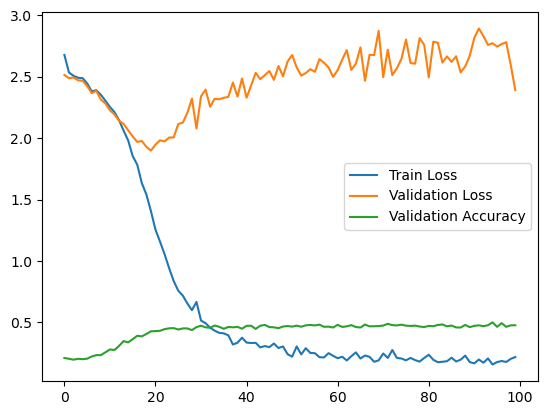

In [40]:
metrics_path = "./train_info/logs_5_12_20_59/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

In [41]:
from ignite.handlers import Checkpoint
import torch

In [ ]:
checkpoint_path = "./train_info/checkpoints_5_12_20_59/best_checkpoint_95_val_accuracy=0.5004.pt"

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

model.eval()

start_epoch = checkpoint["trainer"]['iteration'] / checkpoint["trainer"]['epoch_length']
start_epoch

C:\Users\Vlad\AppData\Local\Temp\ipykernel_11424\910594076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


95.0

In [56]:
checkpoint['trainer']

OrderedDict([('epoch_length', 174), ('max_epochs', 100), ('iteration', 16530)])

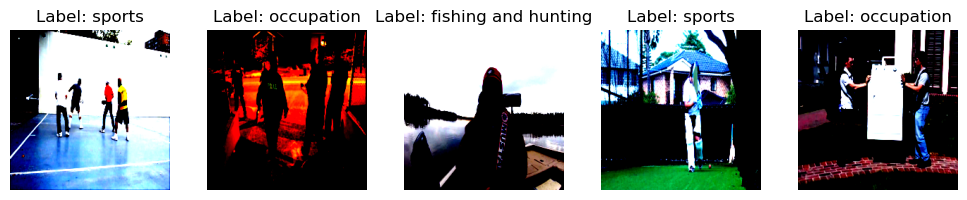

In [65]:
# Получить батч данных
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Вывести первые 5 изображений в одну строку
show_images_row(images[:5], [label.item() for label in labels[:5]], size=(2, 2))

In [82]:
probabilities = torch.softmax(model(images[4].unsqueeze(0).to(device)), dim=1)
probabilities

tensor([[1.4008e-17, 4.3530e-15, 2.1099e-13, 1.0000e+00, 1.3040e-16, 4.1848e-16,
         1.6862e-13, 0.0000e+00, 3.5759e-17, 5.0797e-15, 4.5781e-18, 5.7349e-15,
         3.0980e-22, 4.4588e-18, 1.0627e-17, 0.0000e+00, 1.3075e-19, 0.0000e+00,
         2.1767e-23, 0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [83]:
predicted_class = torch.argmax(probabilities, dim=1).item()
predicted_class

3

In [84]:
id_to_category[predicted_class]

'occupation'